# Cluster Optimization with scMiko

- [Paper](https://www.nature.com/articles/s42003-022-04093-2)
- [Vignette](https://nmikolajewicz.github.io/scMiko/articles/Cluster_Optimization.html)

>ScRNAseq-based cell type identification relies on unsupervised clustering methods; however, resulting cell clusters can vary drastically depending at what resolution is used to perform clustering. The specificity-based resolution selection criterion described here identifies cluster configurations coinciding with maximal marker specificity. Data is first clustered over a range of candidate resolutions, and the top specific marker in each cluster at each resolution is identified using the co-dependency index (CDI) DE method. Subsequently, specificity curves are generated and used to obtain resolution-specific specificity metrics. The resolution at which maximal specificity is observed is taken as the optimal resolution.


In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset.csv"

In [4]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')
srt

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


An object of class Seurat 
11449 features across 22799 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: diffmap, pca, tsne, umap

In [5]:
if (!"scMiko" %in% installed.packages()) {
    devtools::install_github(repo = "NMikolajewicz/scMiko")
}
suppressPackageStartupMessages({library(scMiko)})

## Multi-Resolution Clustering

We cluster the data across a range of candidate resolutions.

In [6]:
resolutions <- seq(0.02, 0.5, by = 0.02)
mc.list <- multiCluster(object = srt, resolutions = resolutions, assay = 'RNA', nworkers = 16, pca_var = 0.9, group_singletons = F, algorithm = 1, return_object = F) # requires a lot of memory
# saveRDS(mc.list, output_file) # takes too long and is at least 10GB

Loading required package: parallel

Loading required package: foreach

2025-03-05 10:14:24.181468: Using 'RNA' assay for clustering...



2025-03-05 10:14:24.895379: Constructing nearest neighbor graph...

2025-03-05 10:14:34.145375: Clustering data...

2025-03-05 10:18:06.986837: Consolidating results...



scCustomize v3.0.1
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.



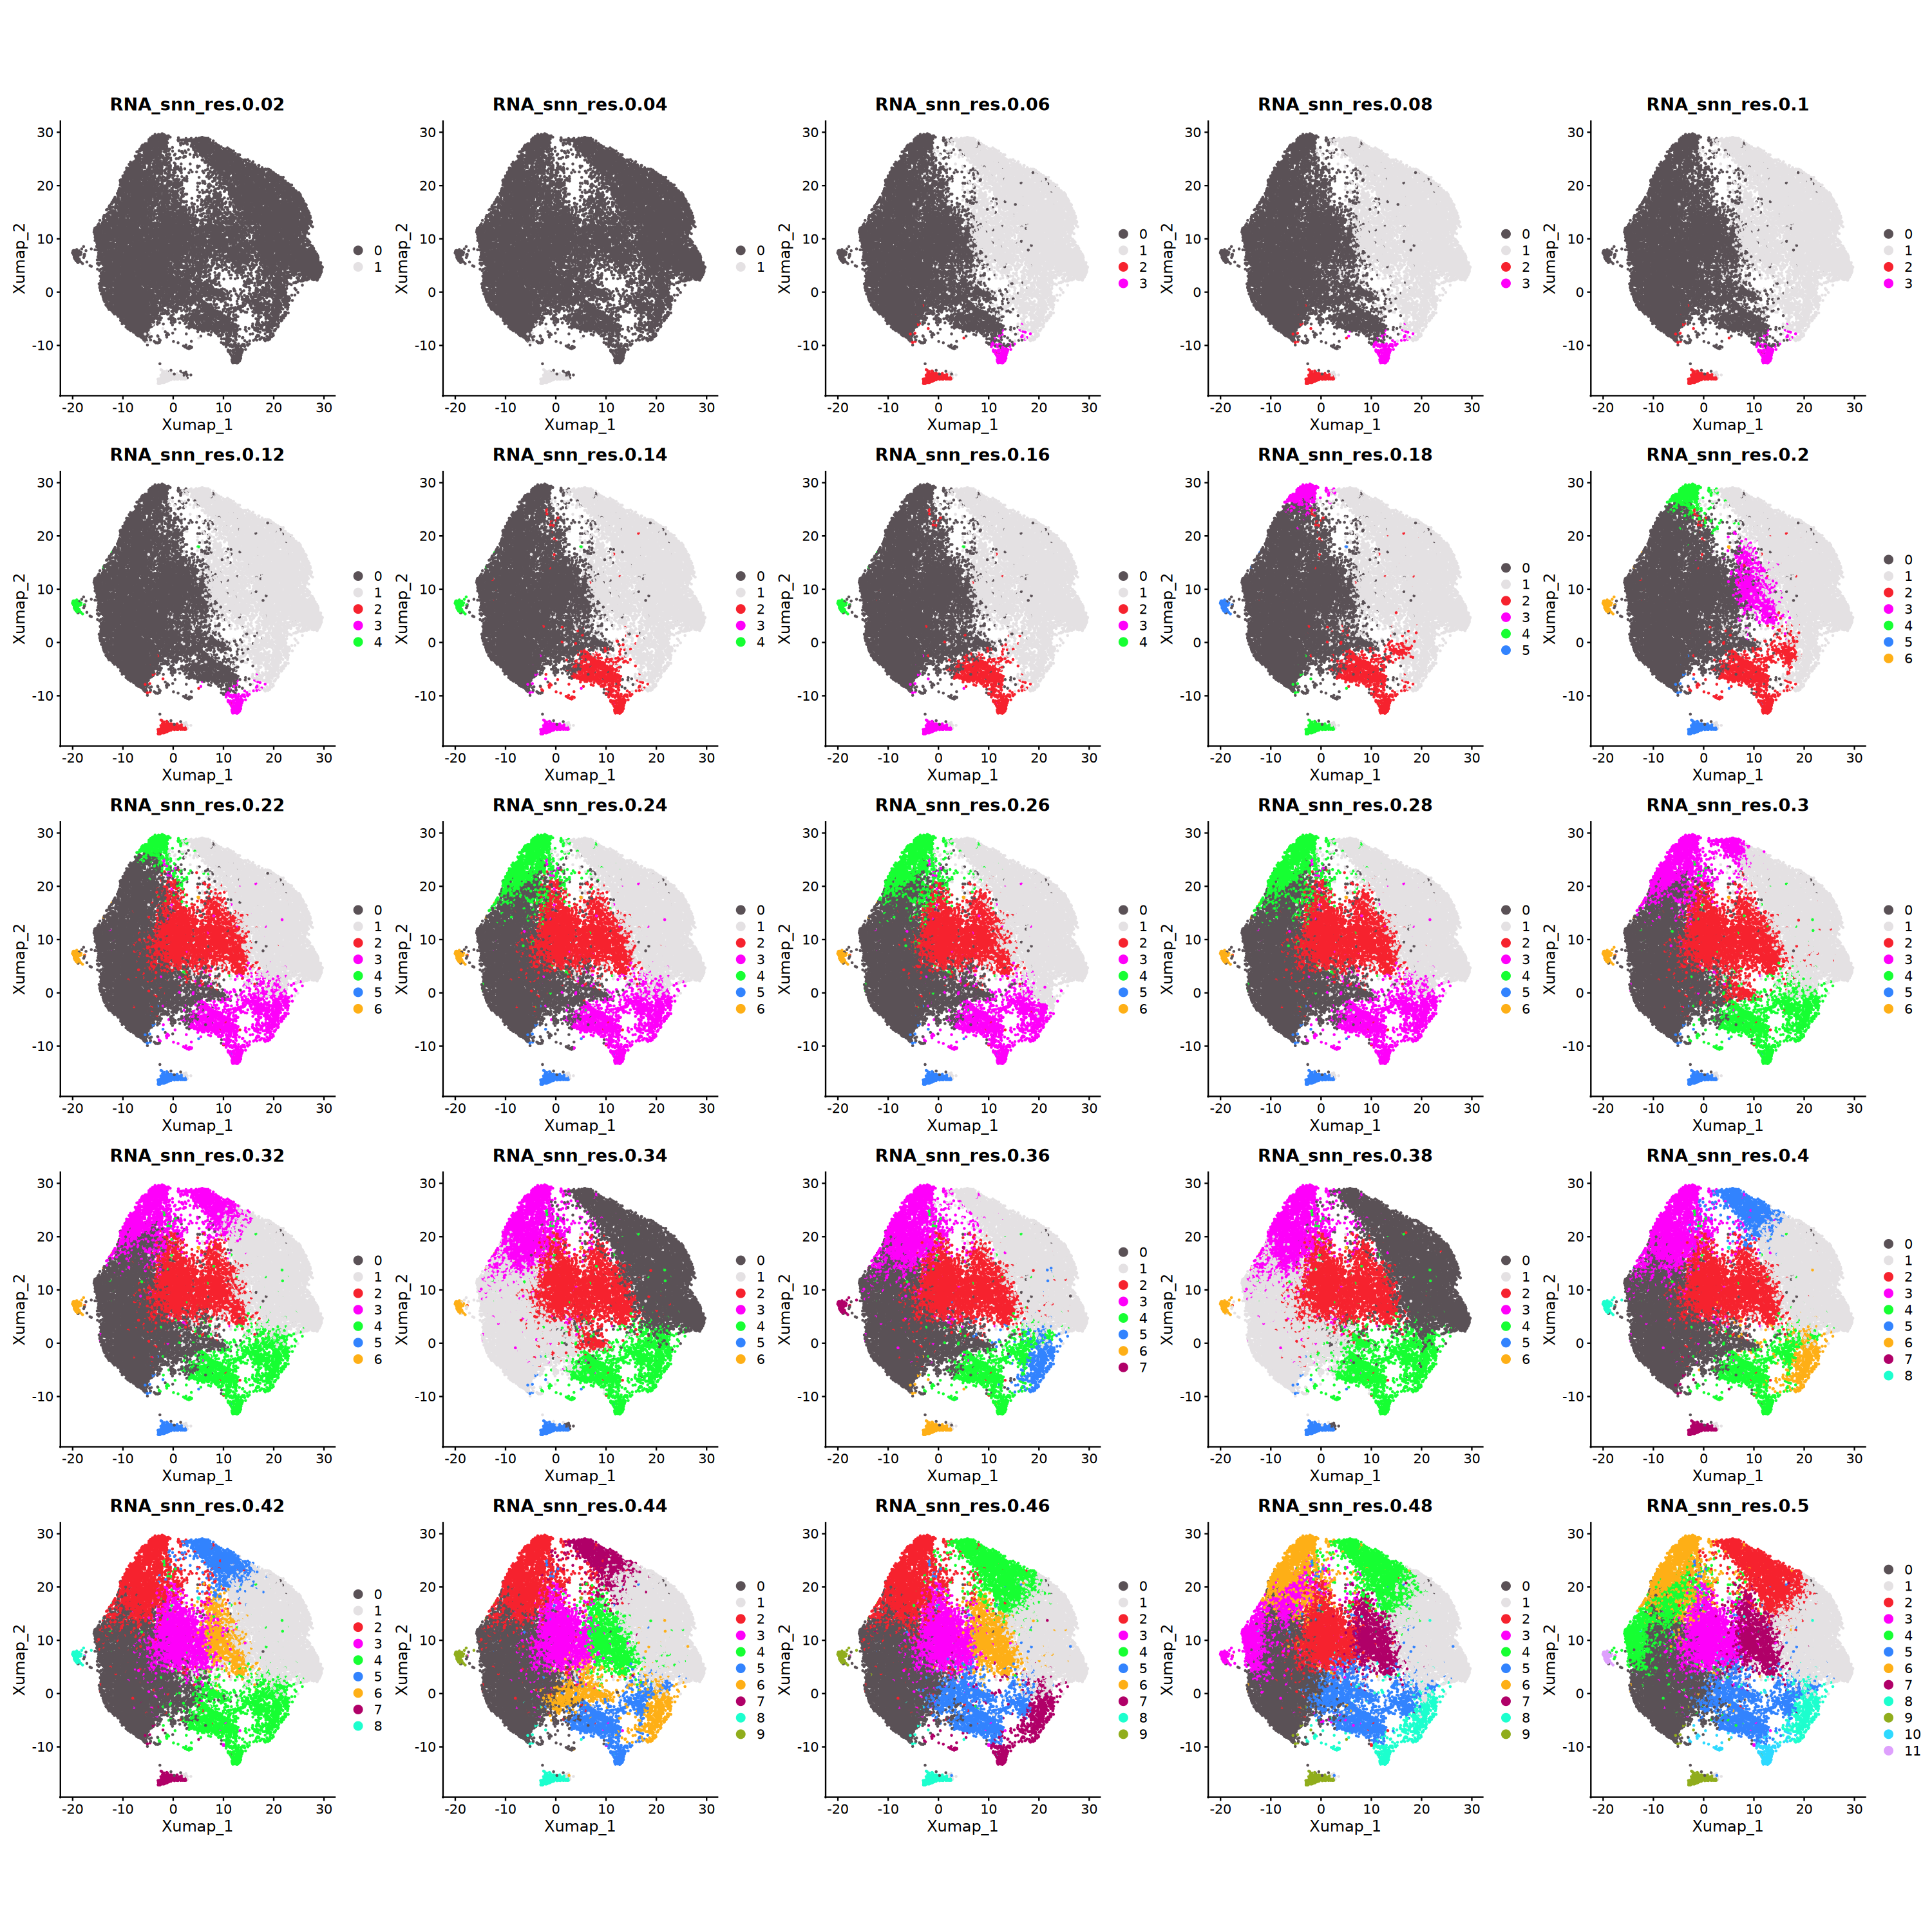

In [7]:
# unwrap results
plt.umap_by_cluster <- mc.list$plots
so.query <- mc.list$object
cr_names <- mc.list$resolution_names
cluster.name <- mc.list$cluster_names
assay.pattern <- mc.list$assay_pattern

# dimplot for all resolutions
library(scCustomize)
options(repr.plot.width = 25, repr.plot.height = 25)
DimPlot_scCustom(so.query, group.by = cluster.name, aspect_ratio = 1, num_columns = 5)

## Specificity-Based Resolution Selection Criterion

>For each cluster configuration, we compute a CDI-based specificity index. The optimal cluster resolution is determined based on the specificity profile.

In [ ]:
ms.list <- multiSpecificity(
    object = so.query,
    cluster_names = cluster.name,
    features = NULL,
    deg_prefilter = T,
    cdi_bins = seq(0, 1, by = 0.01),
    min.pct = 0.1,
    n.workers = 8,
    return_dotplot = T,
    verbose = T
)

2025-03-05 10:18:47.883135: Assessing specificity scores for 25 unique groupings...



2025-03-05 10:18:55.103405: Prefiltering features by presto differential expression analysis...

2025-03-05 10:18:55.119528: Running CDI specificity analysis...

2025-03-05 10:24:30.888234: Subsampling 5000 cells using uniform sampling...

2025-03-05 10:24:32.185281: Identifying cells with non-zero gene expression...

2025-03-05 10:24:41.371719: Quantifying co-expression probabilities...

2025-03-05 10:24:44.25602: Counting co-expression occurences...

2025-03-05 10:29:15.288429: Computing co-dependency indices...

2025-03-05 10:30:04.965061: Normalizing CDI...

2025-03-05 10:30:08.368231: Generating dot plots...



Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


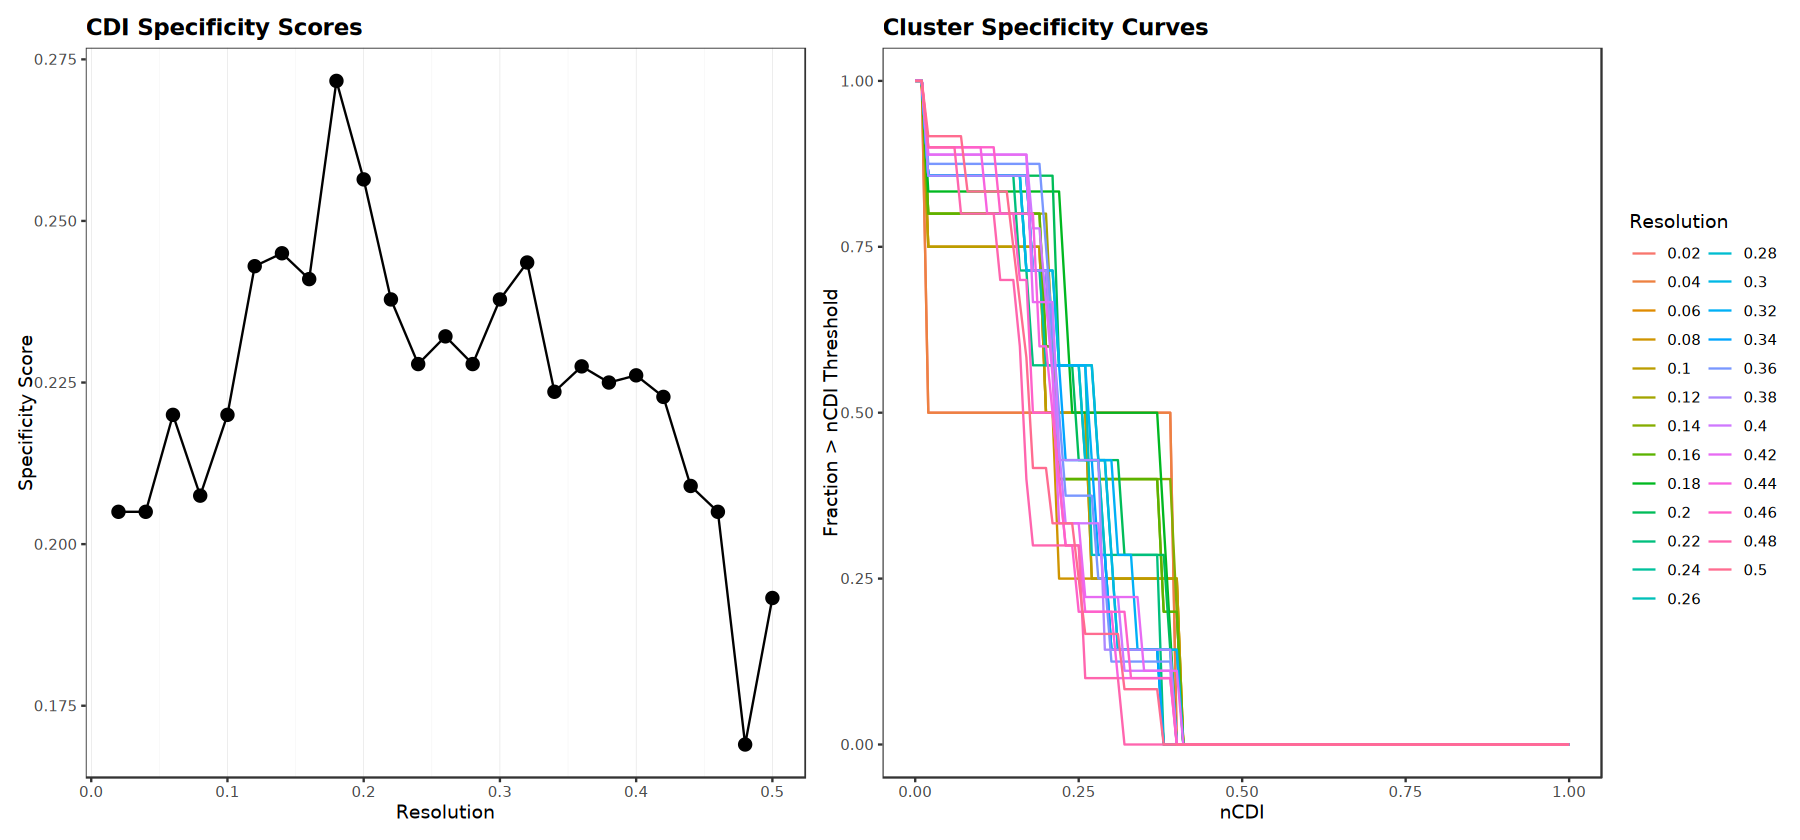

In [9]:
df.summary <- ms.list$specificity_summary

p1 <- ms.list$specificity_raw %>%
    ggplot(aes(x = bin, y = pdeg, group = resolution, color = resolution)) +
    geom_line() +
    theme_miko(legend = T) +
    labs(x = "nCDI", y = "Fraction > nCDI Threshold") +
    labs(title = "Cluster Specificity Curves", color = "Resolution")

p2 <- ms.list$specificity_summary %>%
    ggplot(aes(x = as.numeric(res), y = auc)) +
    geom_point(size = 3) +
    geom_line() +
    theme_miko() +
    labs(x = "Resolution", y = "Specificity Score", title = "CDI Specificity Scores") +
    theme(
        panel.grid.minor = element_line(colour = "grey95", size = 0.1),
        panel.grid.major = element_line(colour = "grey85", size = 0.1),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.y = element_blank()
    )
    
options(repr.plot.width = 15, repr.plot.height = 7)
p2 + p1

In [10]:
cdi_cluster_top <- ms.list$cdi_results %>%
    dplyr::group_by(feature.x) %>%
    dplyr::mutate(cdi_rank = rank(ncdi, ties.method = "random")) %>%
    dplyr::top_n(1, cdi_rank)

cdi_cluster_top %>%
    mutate(resolution = stringr::str_extract(feature.x, "\\d+\\.*\\d*")) -> cdi_cluster_top

# extract clusters from feature.x
cdi_cluster_top %>%
    mutate(cluster = stringr::str_extract(feature.x, "[0-9]+$")) -> cdi_cluster_top

res <- cdi_cluster_top$resolution[4]
cdi_cluster_top2 <- cdi_cluster_top %>% dplyr::filter(resolution %in% res)
cdi_cluster_top2$cluster <- as.numeric(as.character(cdi_cluster_top2$cluster))
cdi_cluster_top2 <- cdi_cluster_top2 %>% dplyr::arrange(cluster)

cdi_features <- cdi_cluster_top2$feature.y
cdi_features

[1] "CDCA7"   "HSD17B2" "NCCRP1"  "ERO1B"

In [ ]:
dir.create("rds", showWarnings = F)
saveRDS(cdi_cluster_top, "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/rds/cdi_cluster_top.rds")
saveRDS(so.query, "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/rds/so.query.rds")
saveRDS(ms.list, "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/rds/ms.list.rds")

### With scaling

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”

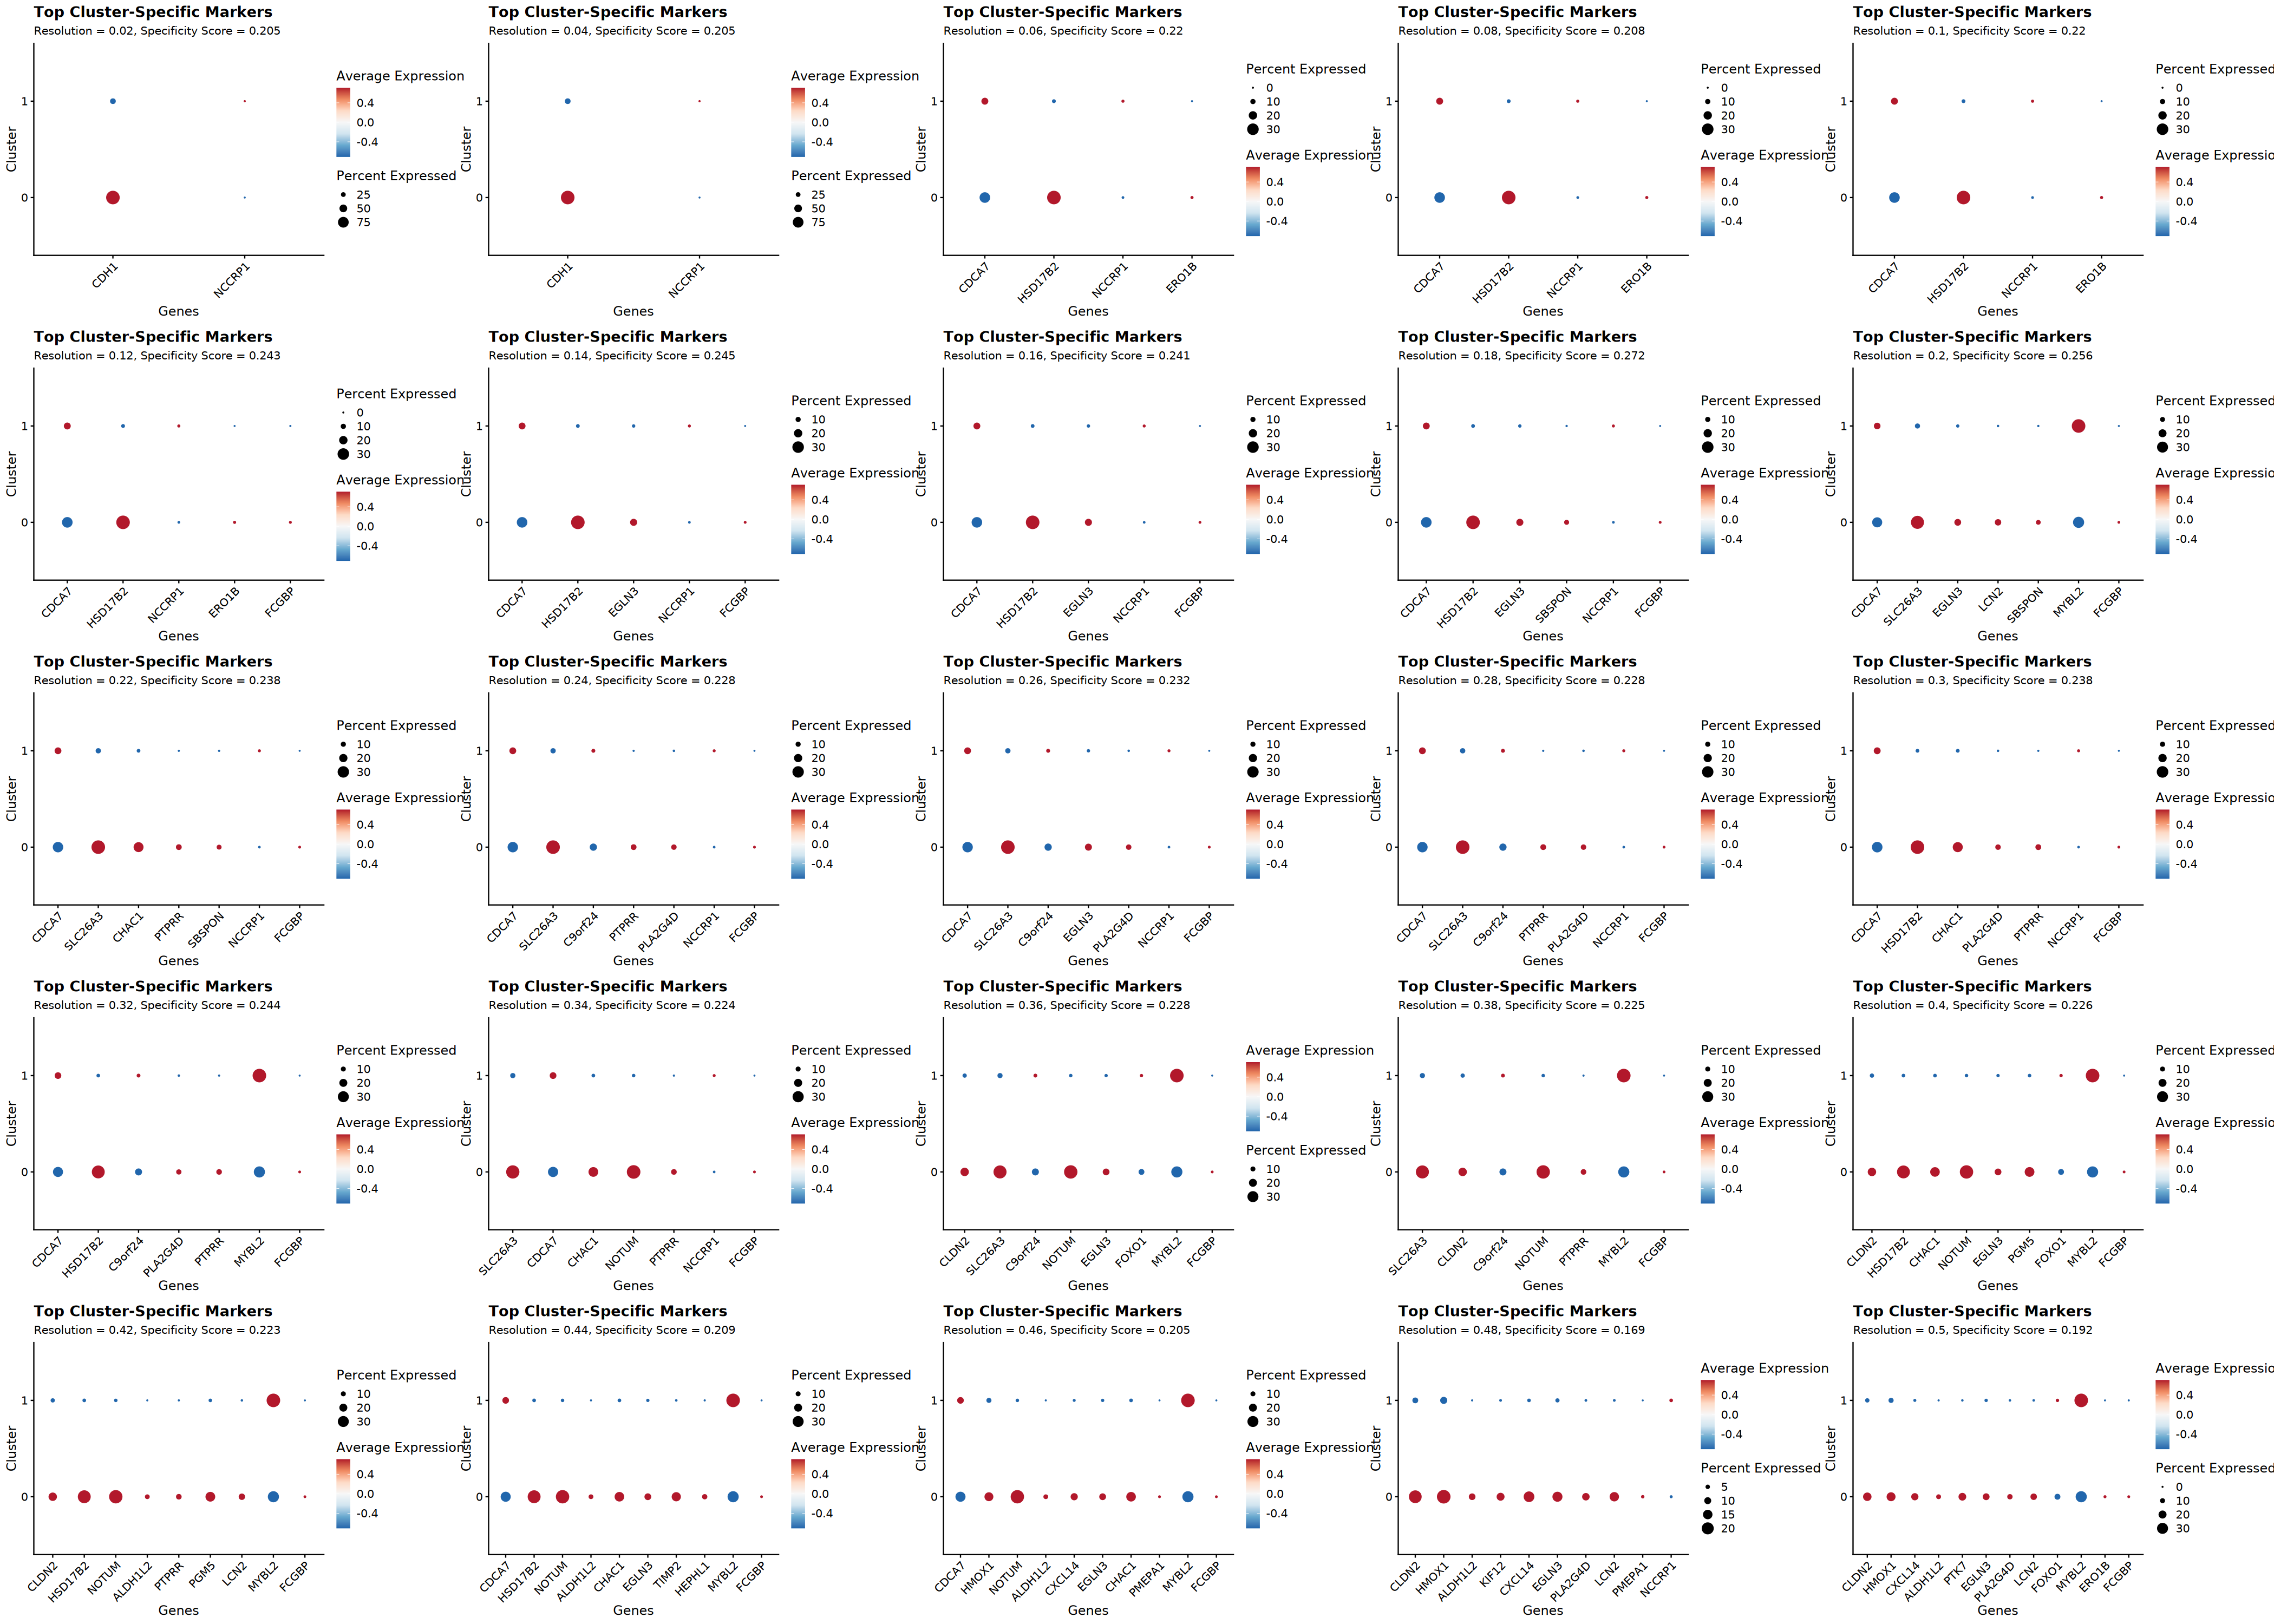

In [11]:
plot_list <- list()
for (res in (cdi_cluster_top$resolution %>% unique() %>% sort())) {
    cdi_cluster_top2 <- cdi_cluster_top %>% dplyr::filter(resolution %in% res)
    cdi_cluster_top2$cluster <- as.numeric(as.character(cdi_cluster_top2$cluster))
    cdi_cluster_top2 <- cdi_cluster_top2 %>% dplyr::arrange(cluster)

    cdi_features <- cdi_cluster_top2$feature.y

    DotPlot(object = so.query, features = cdi_features, group.by = cluster.name, scale = T, cols = 'RdBu') +
        theme(legend.position = "bottom") +
        labs(
            x = "Genes", y = "Cluster", title = "Top Cluster-Specific Markers",
            subtitle = paste0(
                "Resolution = ",
                res, ", Specificity Score = ", signif(ms.list$specificity_summary$auc[ms.list$specificity_summary$res == res], 3)
            )
        ) + theme(legend.position = "right", axis.text.x = element_text(
            angle = 45,
            hjust = 1
        )) -> plot_list[[res]]
}

options(repr.plot.width = 35, repr.plot.height = 25)
cowplot::plot_grid(plotlist = plot_list, align = 'vh', hjust = -1, nrow = 5)

“Scaling data with a low number of groups may produce misleading results.”

Then how does it look like without scaling?

### Without scaling

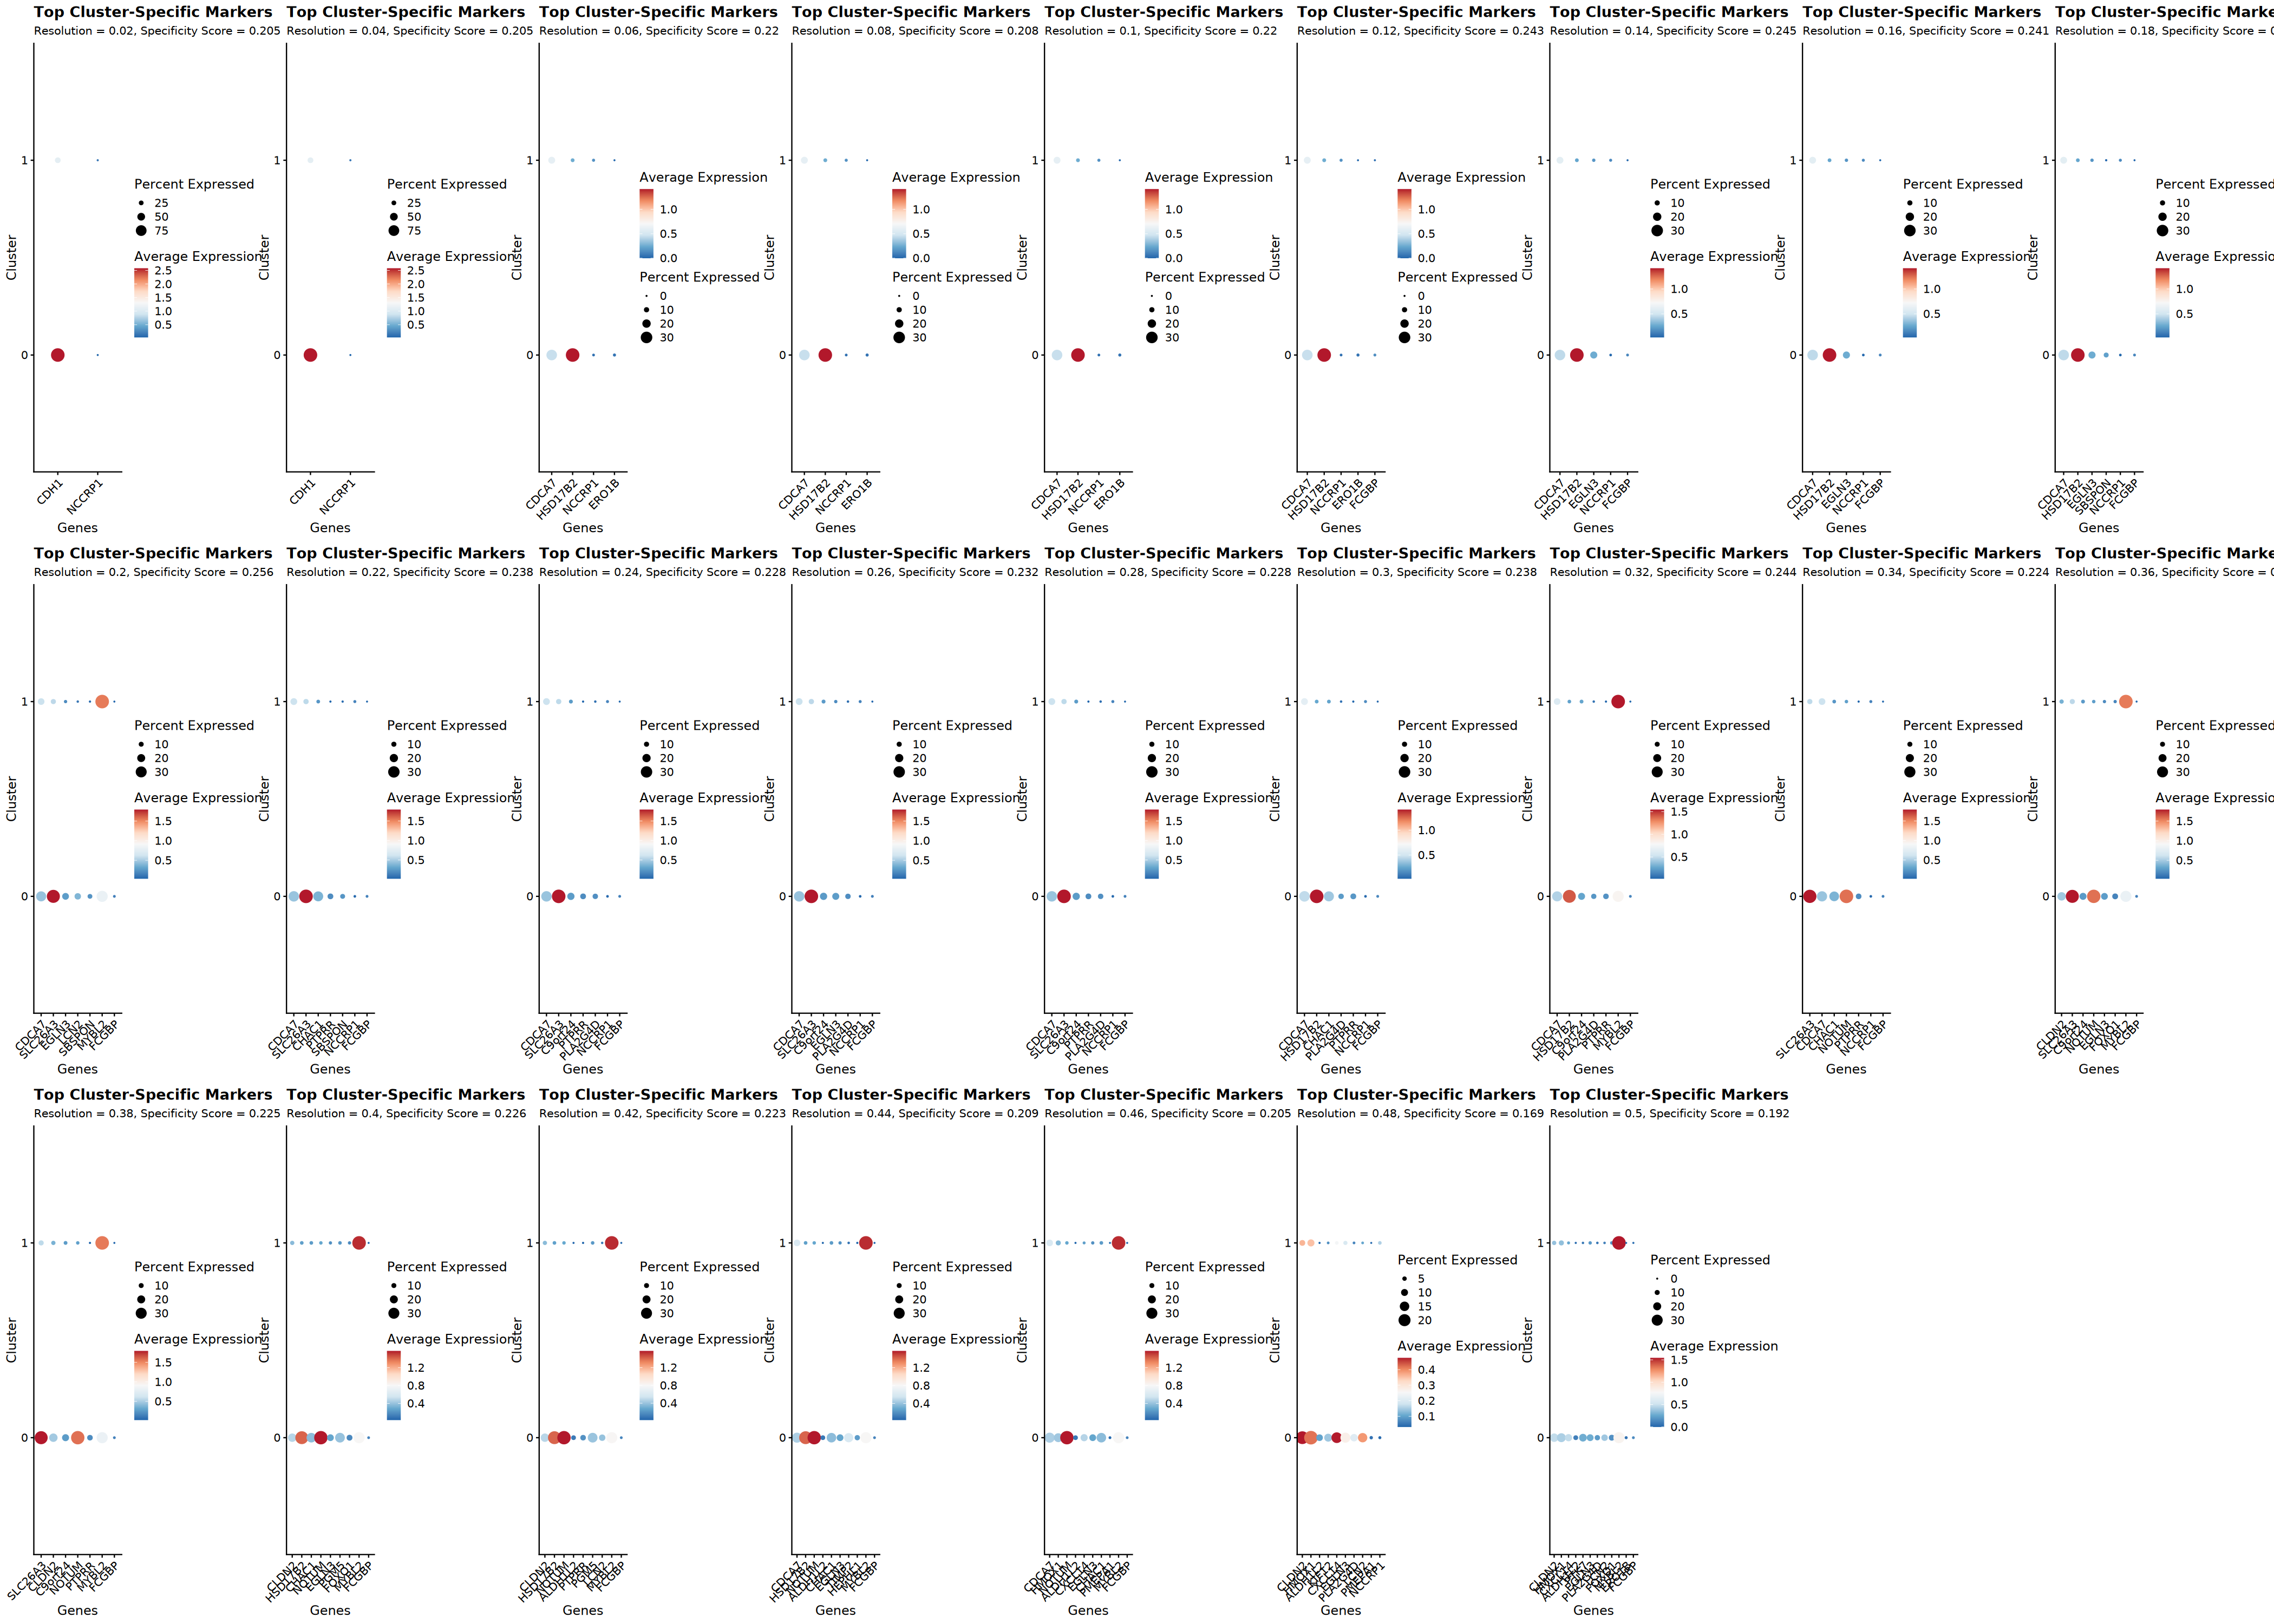

In [ ]:
plot_list <- list()
for (res in (cdi_cluster_top$resolution %>% unique() %>% sort())) {
    cdi_cluster_top2 <- cdi_cluster_top %>% dplyr::filter(resolution %in% res)
    cdi_cluster_top2$cluster <- as.numeric(as.character(cdi_cluster_top2$cluster))
    cdi_cluster_top2 <- cdi_cluster_top2 %>% dplyr::arrange(cluster)

    cdi_features <- cdi_cluster_top2$feature.y

    DotPlot(object = so.query, features = cdi_features, group.by = glue::glue("RNA_snn_res.{resolutions}"), scale = F, cols = 'RdBu') +
        theme(legend.position = "bottom") +
        labs(
            x = "Genes", y = "Cluster", title = "Top Cluster-Specific Markers",
            subtitle = paste0(
                "Resolution = ",
                res, ", Specificity Score = ", signif(ms.list$specificity_summary$auc[ms.list$specificity_summary$res == res], 3)
            )
        ) + theme(legend.position = "right", axis.text.x = element_text(
            angle = 45,
            hjust = 1
        )) -> plot_list[[res]]
}

options(repr.plot.width = 35, repr.plot.height = 25)
cowplot::plot_grid(plotlist = plot_list, align = 'vh', hjust = -1, nrow = 5)

### Choose best clustering resolution

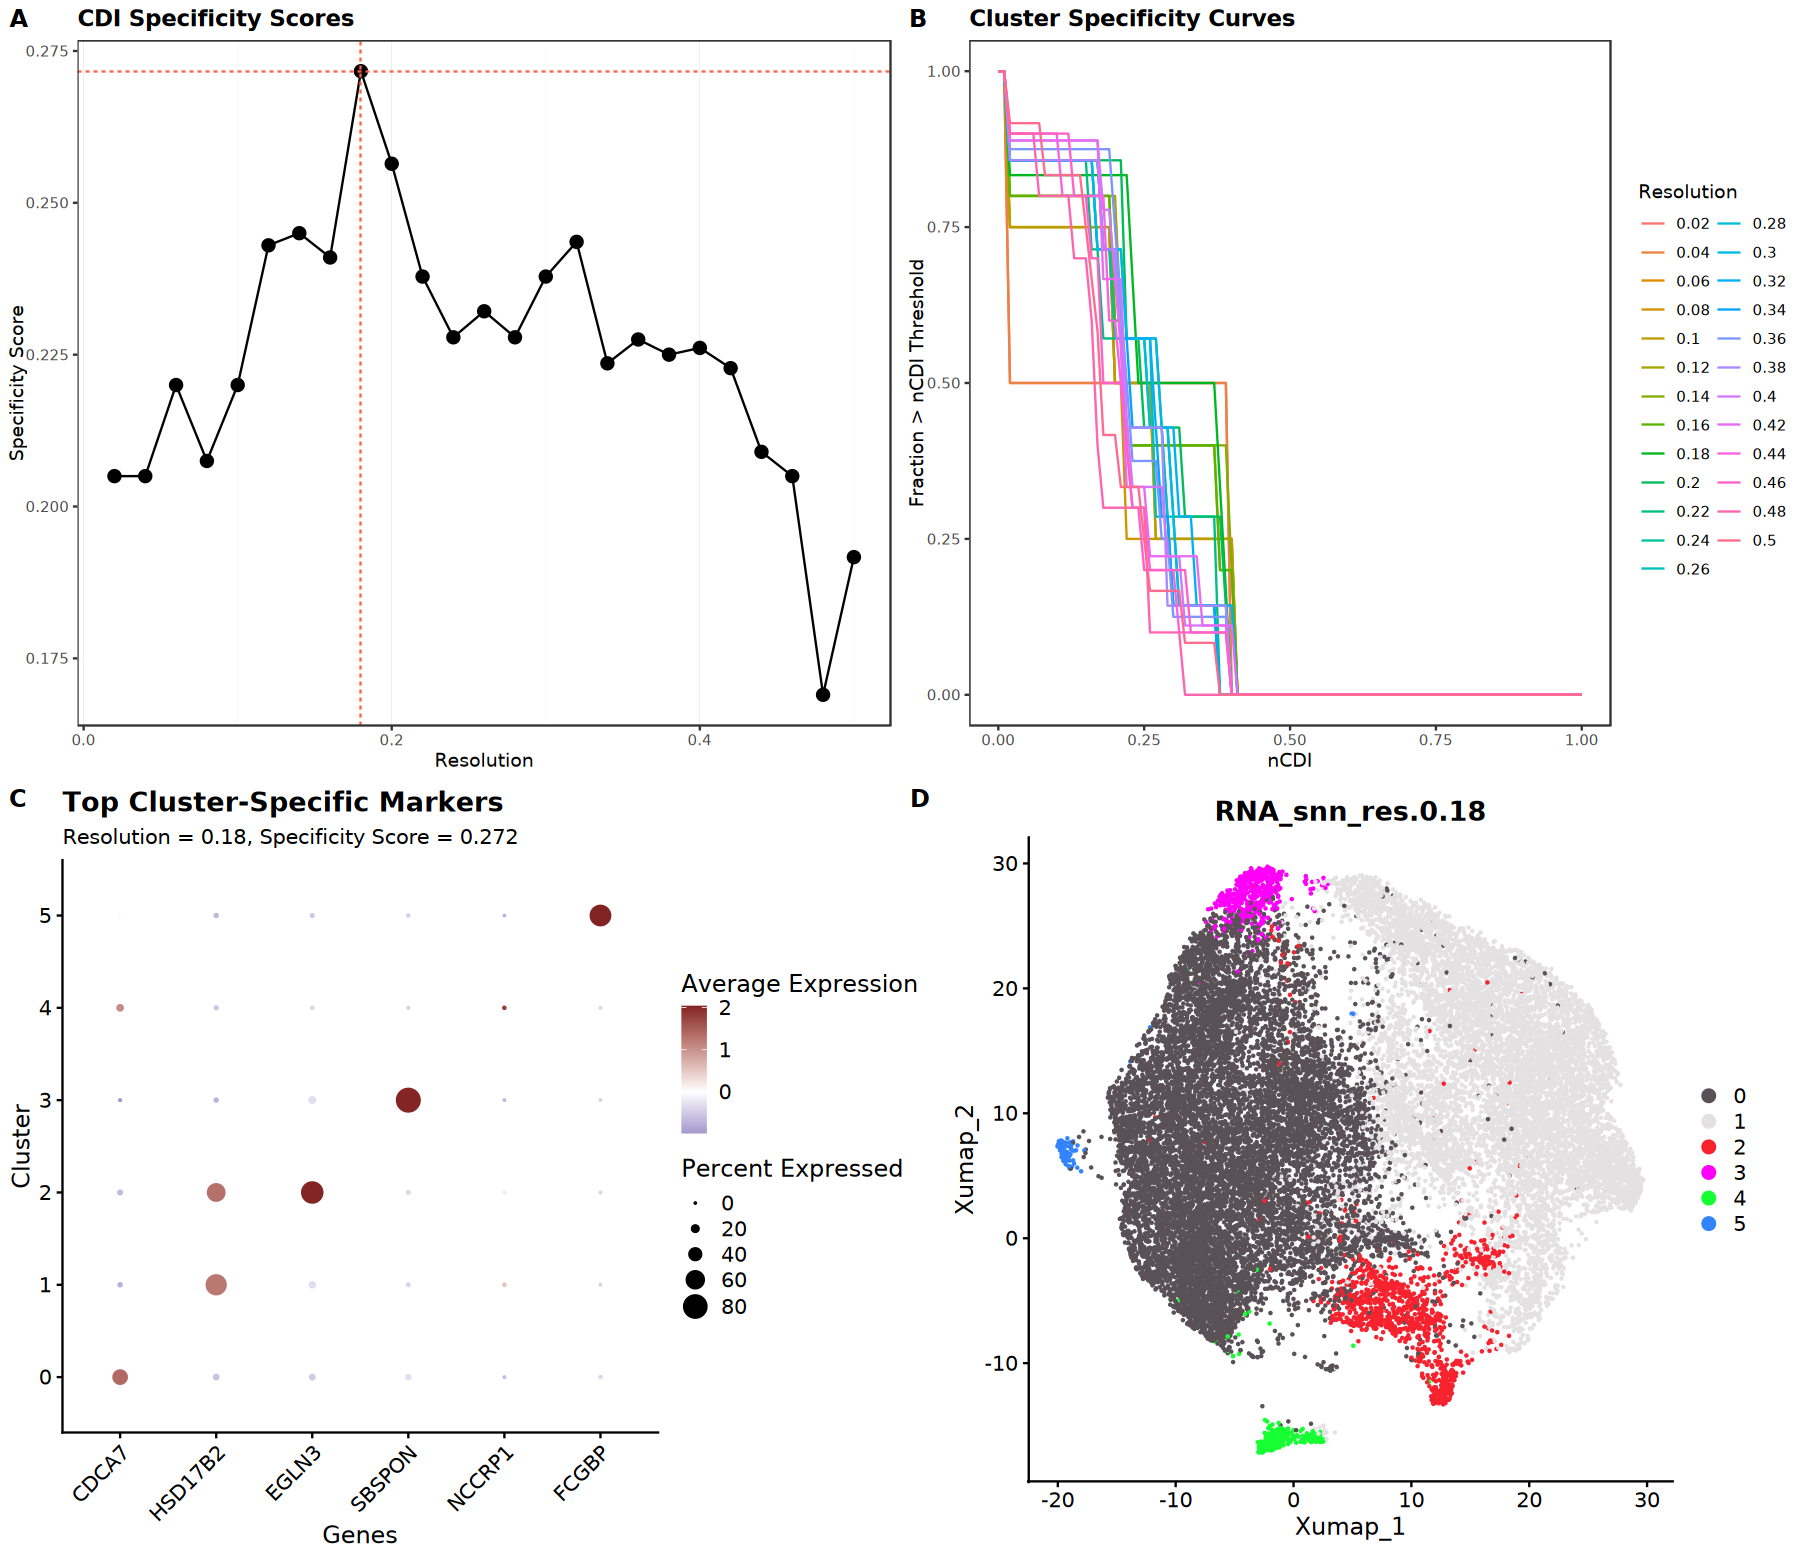

In [13]:
df.raw <- ms.list$specificity_raw
# plt.specificity.umap <- ms.list$umap_plot
plt.clust.spec <- ms.list$auc_plot
plt.auc.spec <- ms.list$resolution_plot
plt.auc.dot <- ms.list$dot_plot

max.auc <- max(df.summary$auc)
speak <- df.summary$res[which.max(df.summary$auc)]

options(repr.plot.width = 15, repr.plot.height = 13)
cowplot::plot_grid(
    plt.auc.spec + geom_hline(yintercept = max.auc, linetype = "dashed", color = "tomato") +
        geom_vline(xintercept = as.numeric(speak), linetype = "dashed", color = "tomato"), 
    plt.clust.spec,
    plt.auc.dot[[speak]] + theme(legend.position = "right", axis.text.x = element_text(
        angle = 45,
        hjust = 1
    )),
    DimPlot_scCustom(so.query, group.by = paste0("RNA_snn_res.", speak), aspect_ratio = 1),
    nrow = 2, labels = "AUTO"
)

In [51]:
write.csv(so.query@meta.data[cluster.name], output_csv)
write.csv(so.query@meta.data[paste0("RNA_snn_res.", speak)],
          gsub(".csv", "_chosen_res.csv", output_csv))

## Multi-level resolutions

>Acknowledging that there exist multiple levels of resolutions that are biologically relevant (e.g., cell types vs. cell subtypes), we can also specify valid cluster configurations at higher resolutions, as suggested by the “elbows” in the specificity plot.